# Image Segmentation and Embedding Generation with FastSAM and CLIP

This notebook provides a step-by-step guide to perform image segmentation using FastSAM and generate image embeddings using the CLIP model. The code is designed to be run in a Google Colab environment.

## Install Required Libraries

```python
!pip install ultralytics


In [4]:
!pip install ultralytics

## Import Necessary Modules

In [10]:
from ultralytics import FastSAM
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Upload an Image

In [11]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to upload an image file

Saving bagpack.jpg to bagpack (1).jpg


## Load the Image

In [12]:
image_path = next(iter(uploaded))  # Get the first uploaded file's name

## Get Original Image Dimensions

In [14]:
# Load the uploaded image using OpenCV
original_image = cv2.imread(image_path)

if original_image is None:
    raise ValueError("Error loading image. Check the path.")

# Get original image dimensions
orig_height, orig_width = original_image.shape[:2]

## Convert Image Format

In [15]:
from PIL import Image

# Convert the OpenCV image (NumPy array) to a PIL image for CLIP processing
original_image_pil = Image.fromarray(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

## Install and Load the CLIP Model

In [17]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mb4phopt
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mb4phopt
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=919074d4bbf82cb89528efe8e1cdaae7119ea735fc0187c81aa348810f512705
  Stored in directory: /tmp/pip-ephem-wheel-cache-v1jiry_s/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [18]:
import torch
import clip

# Load the CLIP model and preprocess function
clip_model, preprocess = clip.load("ViT-B/32")

# Preprocess the image for CLIP
image_input = preprocess(original_image_pil).unsqueeze(0)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 47.5MiB/s]


## Generate Image Embeddings

In [19]:
with torch.no_grad():
    image_embeddings = clip_model.encode_image(image_input)

## Save the Embeddings

In [20]:
# Save the embeddings as a .npy file
np.save('image_embeddings.npy', image_embeddings.numpy())  # Save as .npy file

print("Image embeddings saved as 'image_embeddings.npy'")

Image embeddings saved as 'image_embeddings.npy'


## Load FastSAM Model

In [21]:
model = FastSAM("FastSAM-s.pt")  # or "FastSAM-x.pt" for a larger model

100%|██████████| 22.7M/22.7M [00:00<00:00, 30.9MB/s]


## User Input for Segmentation

In [42]:
# Take user input for segmentation prompt
user_prompt = input("Enter the object you want to segment: ")

# Run inference with a text prompt
results = model(image_path, texts=user_prompt)

Enter the object you want to segment: laptop

image 1/1 /content/bagpack (1).jpg: 640x640 1 object, 828.1ms
Speed: 5.6ms preprocess, 828.1ms inference, 9585.9ms postprocess per image at shape (1, 3, 640, 640)


## Visualize Results

Number of masks found: 1


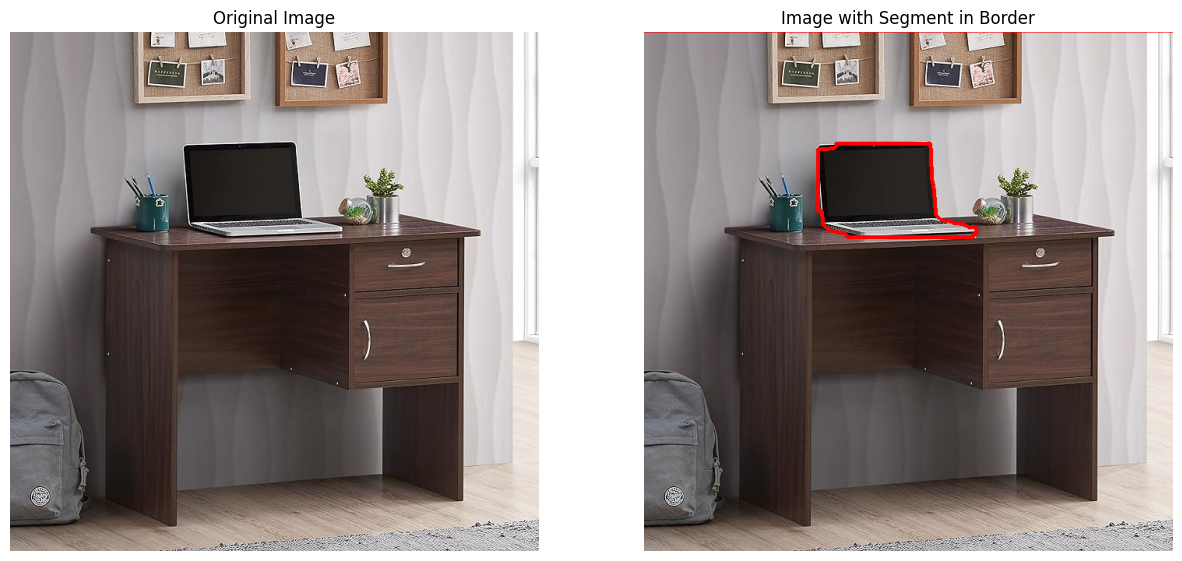

In [46]:
if isinstance(results, list):
    for result in results:
        if result.masks is not None:
            masks_data = result.masks.data.numpy()  # Convert mask tensor to NumPy array

            print(f"Number of masks found: {masks_data.shape[0]}")

            # Create a blank output image (same size as original)
            output_image = original_image.copy()

            # Check if any masks are found
            if masks_data.shape[0] > 0:
                # Process the first mask (assuming it's the one we want)
                mask_array = masks_data[0] > 0  # Create a binary mask (True where mask is present)

                # Resize mask to match original image dimensions if necessary
                if mask_array.shape != (orig_height, orig_width):
                    mask_array_resized = cv2.resize(mask_array.astype(np.uint8), (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)
                else:
                    mask_array_resized = mask_array

                # Create a colored overlay for visualization
                colored_mask = np.zeros_like(original_image)  # Create an empty image with the same shape as original
                colored_mask[mask_array_resized] = [0, 0, 255]  # Set masked area to red (BGR format)

                # Draw contours around the detected object
                contours, _ = cv2.findContours(mask_array_resized.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                for contour in contours:
                    cv2.drawContours(output_image, [contour], -1, (0, 0, 255), 3)  # Draw red

                output_image[mask_array_resized] = [0, 0, 255]  # Fill masked area with red

                # Display final images
                plt.figure(figsize=(15, 10))

                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
                plt.title('Image with Segment in Border')
                plt.axis('off')

                plt.show()
            else:
                print("No valid masks found in this result.")
        else:
            print("No masks found in this result.")
else:
    print("Unexpected result format:", type(results))

## Function to Apply Red Mask

In [47]:
def apply_red_mask(image, mask):
    # Ensure mask is a boolean array
    mask = mask.astype(bool)

    # Create a red mask
    red_mask = np.zeros_like(image)
    red_mask[mask] = [0, 0, 255]  # Fill the mask area with red (BGR format)

    # Blend the original image and the red mask
    output_image = cv2.addWeighted(image, 0.7, red_mask, 0.3, 0)
    return output_image

## Final Visualization with Combined Masks

Number of masks found: 1


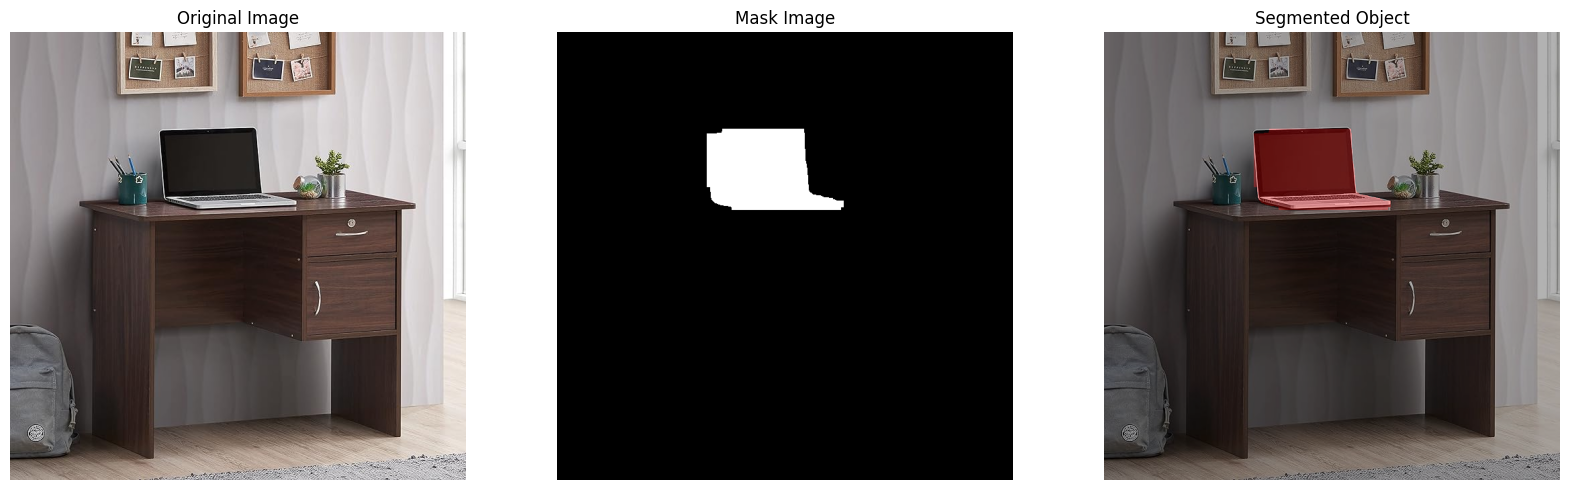

Raw mask image saved as 'raw_mask_image.png'.


In [48]:
if isinstance(results, list):
    for result in results:
        if result.masks is not None:
            masks_data = result.masks.data.numpy()  # Convert mask tensor to NumPy array

            print(f"Number of masks found: {masks_data.shape[0]}")

            # Create a blank output image (same size as original)
            output_image = original_image.copy()
            combined_mask = np.zeros((orig_height, orig_width), dtype=np.uint8)

            # Check if any masks are found
            if masks_data.shape[0] > 0:
                for mask_array in masks_data:
                    # Create a binary mask (True where mask is present)
                    binary_mask = mask_array > 0

                    # Resize mask to match original image dimensions if necessary
                    if binary_mask.shape != (orig_height, orig_width):
                        binary_mask_resized = cv2.resize(binary_mask.astype(np.uint8), (orig_width, orig_height), interpolation=cv2.INTER_NEAREST)
                    else:
                        binary_mask_resized = binary_mask

                    # Update combined mask
                    combined_mask = combined_mask | binary_mask_resized

                # Apply red mask on the combined mask
                output_image = apply_red_mask(original_image, combined_mask)

                # Create a mask image
                mask_image = np.zeros((orig_height, orig_width, 3), dtype=np.uint8)  # Initialize a color image
                mask_image[combined_mask > 0] = [255, 255, 255]  # White mask for segmented areas

                # Display final images
                plt.figure(figsize=(20, 10))

                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
                plt.title('Original Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB))
                plt.title('Mask Image')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
                plt.title('Segmented Object')
                plt.axis('off')

                plt.show()

                # Save the mask image
                cv2.imwrite('raw_mask_image.png', mask_image)
                print("Raw mask image saved as 'raw_mask_image.png'.")
            else:
                print("No valid masks found in this result.")
        else:
            print("No masks found in this result.")
else:
    print("Unexpected result format:", type(results))

# Shifting Segmented Object and Adjusting Background

This section of the notebook implements functionality to shift a segmented object within the original image while adjusting the background accordingly.

## Define the Function to Shift the Segmented Object

In [70]:
def shift_segmented_object(original_image, combined_mask, x_shift, y_shift):
    shifted_image = np.zeros_like(original_image)
    mask_shifted = np.zeros_like(combined_mask)

    # Create an output image to highlight the original position
    output_image = original_image.copy()

    # Loop through the original mask and shift the pixels
    for y in range(combined_mask.shape[0]):
        for x in range(combined_mask.shape[1]):
            if combined_mask[y, x]:
                new_x = min(max(x + x_shift, 0), original_image.shape[1] - 1)
                new_y = min(max(y + y_shift, 0), original_image.shape[0] - 1)
                shifted_image[new_y, new_x] = original_image[y, x]
                mask_shifted[new_y, new_x] = 1  # Update shifted mask

                # Mark the original position with red
                output_image[y, x] = [0, 0, 255]  # Set the original position to red

    # Fill in the area of the original object in the background
    mask_to_inpaint = combined_mask.astype(np.uint8)
    inpainted_area = cv2.inpaint(output_image, mask_to_inpaint, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Apply the shifted mask to the output image
    output_image[mask_shifted > 0] = shifted_image[mask_shifted > 0]

    # Blend the inpainted area with the output image
    output_image = cv2.addWeighted(output_image, 1, inpainted_area, 0.5, 0)

    return output_image

## Create a Combined Mask

In [72]:
# Create a combined mask from the segmentation results
combined_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)

if isinstance(results, list):
    for result in results:
        if result.masks is not None:
            masks_data = result.masks.data.numpy()
            for mask_array in masks_data:
                # Resize the mask to match original image dimensions
                mask_resized = cv2.resize(mask_array.astype(np.uint8), (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
                binary_mask = mask_resized > 0
                combined_mask = combined_mask | binary_mask

## Get User Input for Shifting

In [78]:
x_shift = int(input("Enter x shift (positive for right, negative for left): "))
y_shift = int(input("Enter y shift (positive for down, negative for up): "))

Enter x shift (positive for right, negative for left): 0
Enter y shift (positive for down, negative for up): 300


## Shift the Segmented Object

In [79]:
shifted_image = shift_segmented_object(original_image, combined_mask, x_shift, y_shift)

## Display the Original and Shifted Images

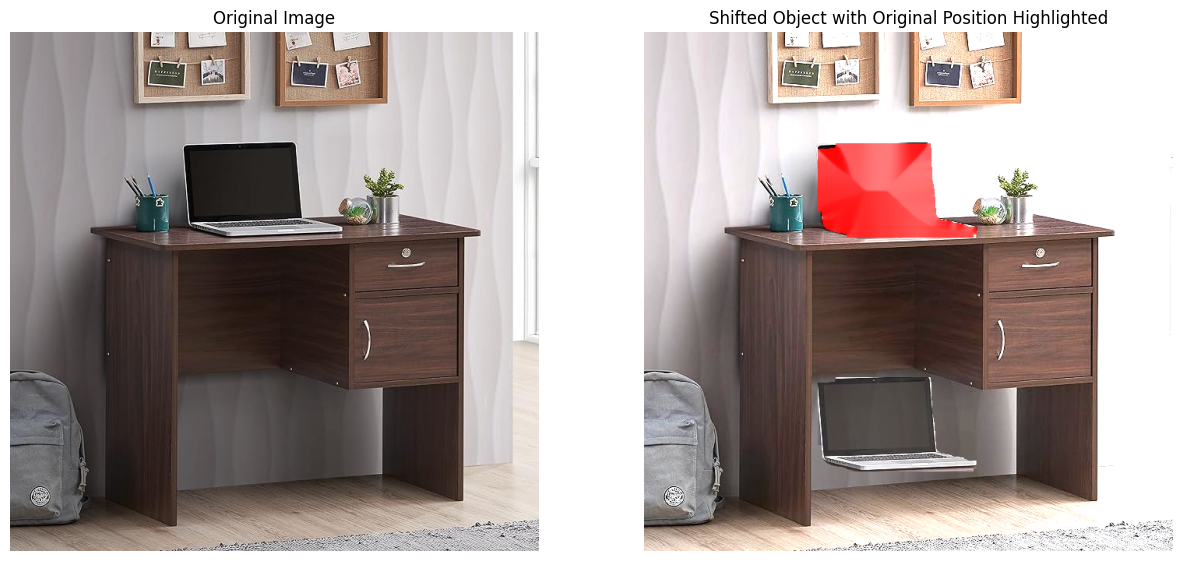

In [80]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(shifted_image, cv2.COLOR_BGR2RGB))
plt.title('Shifted Object with Original Position Highlighted')
plt.axis('off')

plt.show()